# Importing Library

In [48]:
import numpy as np
import pandas as pd
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt
import re
from geopy import distance
import time
import math

# Function and Object

## Simulation

### Function

#### Reading and Preprocessing Data

In [49]:
def read_excel(data):
    df = pd.read_excel('Data Prep.xlsx', index_col=0, sheet_name=data)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

def read_excel_revisi(data):
    df = pd.read_excel('Data Prep Revisi.xlsx', index_col=0, sheet_name=data)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df



def mirroring(df): 
    df_c = df.copy()
    df = df.fillna(0)
    df = df + df.T
    df[df_c.isnull() & (df == 0)] = None
    return df

def set_same_zero(df):
    df_column = df.columns.values
    df_column = set(df_column)
    df_index = df.index.values
    df_index = set(df_index)
    same_port = df_index & df_column

    # making same port data into 0 
    for i in same_port:
        df[i][i]=0
    return df

def calculate_availibility(wave_status):
    wave_status['PR_availability'] = wave_status['wave_h']<2
    return wave_status

In [50]:
def fill_mean(df):
    df = df.fillna(df.mean().mean())
    return df

#### Coordinate Data

In [51]:
#CONVERT DMS TO DECIMAL
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'E' or direction == 'N':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[°\'"]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])
    return lat

#### Choosing and making port

In [52]:
def quickport(port_name):
    name = ports[ports['port'] == port_name]['port'].values[0]
    port_type = ports[ports['port'] == port_name]['port_type'].values[0]
    return Port(name,port_type)

In [53]:
def chooseport(port_name):
    port_name = port_name.rstrip()
    port_name = port_name.lstrip()
    return ports[ports['port'] == port_name]['port_object'].iloc[0]

In [54]:
def chooseship(ship_name):
    ship_name = ship_name.rstrip()
    ship_name = ship_name.lstrip()
    return ship_df[ship_df['Ship_Name'] == ship_name]['object'].iloc[0]

In [55]:
def add_TL_route(route):
    finished = False
    i = 0
    while finished == False:
        current_item = route[i]
        if current_item.name in ['Ambon','Saumlaki','Tual']:
            k=0
            for j in movable_TL[current_item.name]:
                k+=1
                route.insert(i+k,j)
            i+=len(movable_TL[current_item.name])
        i+=1
        if len(route) <= i:
            break
    return route

In [56]:
def port_items(port):
    global all_port_item
    item_list = all_port_item[all_port_item['Pelabuhan'] == port]
    return item_list

In [57]:
def find_distance(port_a,port_b):
#     print(port_a)
#     print(port_b)
    a = port_loc[port_loc['Nama Pelabuhan'] == port_a]
    b = port_loc[port_loc['Nama Pelabuhan'] == port_b]
#     print(a)
#     print(b)
#     print(a['Lat_decimal'].values[0])
#     print(a['Long_decimal'].values[0])
#     print(b['Lat_decimal'].values[0])
#     print(b['Long_decimal'].values[0])
    dist = distance.distance((a['Lat_decimal'].values[0],a['Long_decimal'].values[0]),(b['Lat_decimal'].values[0],b['Long_decimal'].values[0])).miles
    return dist

In [58]:
def choose_char(ship_type):
    global TL_char, PL_char, PR_char
    if ship_type=='TL':
        ship_char = TL_char
    elif ship_type=='PL':
        ship_char = PL_char
    elif ship_type=='PR':
        ship_char = PR_char
    return ship_char

In [59]:
def per_item_revenue(data):
#     distance = find_distance(data['Pelabuhan'],data['Tujuan Pelabuhan'])
    distance = data['Jarak']
    Bobot = data['Bobot']
    BJT = biaya_jarak_teus[data['Pelabuhan']][data['Tujuan Pelabuhan']]
#     BJT = biaya_jarak_teus[data['Pelabuhan Asal']][data['Tujuan Pelabuhan']]
    income = distance*Bobot*BJT
    return income

In [60]:
def port_revenue(storage_df):
    total_income = 0
    global gl, gli
    gl = storage_df
    for i in storage_df.index:
        gli = i
        income = per_item_revenue(storage_df.loc[i])
        total_income += income
    return total_income

In [61]:
def item_left(df):
    return int(df['Bobot'].sum())

In [62]:
def find_movable_port(ship_type,port_name):
    if ship_type == 'TL':
        flag = False
    elif ship_type == 'PR':
        flag = True
    else:
        added_route = []
        return added_route
    r_list = special_PR[port_name].dropna().to_list()
    route_list = wave_status[wave_status['Port'].isin(r_list)][wave_status['PR_availability'] == flag]['Port'].to_list()
    added_route = []
    for i in route_list:
        added_route.append(chooseport(i))
    return added_route

In [63]:
def all_item(available_ship,ports):
    itemdf = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan','Jarak'])
    itemdf.index.name = 'code barang'
    for i in ports['port_object']:
        itemdf = itemdf.append(i.demand)
    for i in available_ship:
        itemdf = itemdf.append(i.storage)
    return itemdf

In [64]:
def create_route(route_list):
    route = []
    for i in route_list:
        route.append(chooseport(i))
    return route
    

In [65]:
def total_revenue(available_ship):
    total_revenue = 0
    for i in available_ship:
        total_revenue += i.revenue
    return total_revenue

In [66]:
def get_route(df):
    return df['Route'].to_list()

In [67]:
def create_ship_df(excel = 'Data Ship.xlsx'):
    x1 = pd.ExcelFile(excel)
    names = x1.sheet_names
    ship_df = pd.DataFrame()
    for i in names:
        ship_data = x1.parse(i)
        port_list = create_route(get_route(ship_data))
        this_ship_df = pd.DataFrame(data = {'Ship_Name': [ship_data['Ship_Name'].iloc[0]],
                                           'Ship_Type': [ship_data['Ship_Type'].iloc[0]],
                                           'original_port': [ship_data['original_port'].iloc[0]],
                                            'object':[Ship(ship_data['Ship_Type'].iloc[0],
                                                             route = port_list,
                                                             name=ship_data['Ship_Name'].iloc[0],
                                                             initial_port = ship_data['original_port'].iloc[0])]
                                           })
        ship_df = ship_df.append(this_ship_df)

    ship_df = ship_df.reset_index(drop=True)
    return ship_df

In [68]:
def adjust_wave():
    global wave_status,route_PR_Ambon,route_PR_Tual,route_PR_Saumlaki,movable_TL
    wave_status['wave_h'] = wave_status['wave_h'].apply(lambda x: random.random()*4)
    wave_status = calculate_availibility(wave_status)
    movable_TL = {'Ambon' : find_movable_port('TL','Ambon'),
              'Tual' : find_movable_port('TL','Tual'),
              'Saumlaki' : find_movable_port('TL','Saumlaki')}
    route_PR_Ambon = [chooseport('Ambon')]+find_movable_port('PR','Ambon')
    route_PR_Tual = [chooseport('Tual')]+find_movable_port('PR','Tual')
    route_PR_Saumlaki = [chooseport('Saumlaki')]+find_movable_port('PR','Saumlaki')



In [69]:
def shuffle_route(available_ship):
    for i in available_ship:
        random.shuffle(i.route)

In [70]:
def initial_port_to_first(available_ship):
    for i in available_ship:
        init_index = i.route.index(i.initial_port)
        intial_port_to_front = i.route.pop(init_index)
        i.route.insert(0, intial_port_to_front)

In [71]:
def redefine_route():
    global route_PR_Ambon,route_PR_Tual,route_PR_Saumlaki,ship_df
    ship_df[ship_df['Ship_Type'] == 'PR'][ship_df['original_port'] == 'Ambon']['object'].iloc[0].route = route_PR_Ambon
    ship_df[ship_df['Ship_Type'] == 'PR'][ship_df['original_port'] == 'Tual']['object'].iloc[0].route = route_PR_Tual
    ship_df[ship_df['Ship_Type'] == 'PR'][ship_df['original_port'] == 'Saumlaki']['object'].iloc[0].route = route_PR_Saumlaki

    for i in ship_df[ship_df['Ship_Type'] == 'TL']['object'].to_list():
        i.route =  add_TL_route(i.route)
        
                

In [72]:
def port_sequence(ship):
    if ship.destination_dist<=ship.current_dist:
        ship.move_port()
#         print('')
#         print('')
#         print('')
#         print('')
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
#         print('ship_type: '+ship.ship_type)
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
#         print('BEFORE')
#         print('current port:' + ship.current_port.name)
#         print('')
#         print('PORT DEMAND:')
#         print(ship.current_port.demand)
#         print('')
#         print('SHIP STORAGE:')
#         print(ship.storage)
        ship.move_storage()
#         print('oOoOoOoOoOoOoOoOoOoOoOoO')
#         print('AFTER')
#         print('current port:' + ship.current_port.name)
#         print('')
#         print('PORT DEMAND:')
#         print(ship.current_port.demand)
#         print('')
#         print('SHIP STORAGE:')
#         print(ship.storage)
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        ship.find_destination()
        ship.destination_dist = find_distance(ship.destination.name, ship.current_port.name)
        ship.current_dist = 0
    elif ship.destination_dist>ship.current_dist:
        ship.storage['Jarak'] = ship.storage['Jarak']+ship.speed
        ship.current_dist+=ship.speed

        


In [73]:
def run_simulation():
    new_port_item = all_item(available_ship,ports)
    remaining = item_left(new_port_item)
    i=0
    remaining_history = []
    revenue_history = []
    tic = time.clock()
    while remaining>0:
        i +=1
        for ship in available_ship:
            port_sequence(ship)
            print('{} revenue: {}'.format(ship.name,ship.revenue))
        new_port_item = all_item(available_ship,ports)
        remaining = item_left(new_port_item)
        revenue = total_revenue(available_ship)
        print('************************************************')
        print('revenue: {}'.format(revenue))
        print('remaining: ' + str(remaining))
        print('iteration: ' + str(i))
        print('************************************************')
        remaining_history.append(remaining)
        revenue_history.append(revenue)
        if i>=7000:
            break
    toc = time.clock()
    process_time = toc-tic
    return remaining_history,revenue_history,process_time


In [74]:
def analyse_simulation(remaining_history,revenue_history):
    plt.plot(remaining_history)
    plt.show()
    plt.plot(revenue_history)
    plt.show()
    print('Total Revenue: {}'.format(revenue_history[-1]))

In [75]:
def create_ports_object(ports):
    ports['port_object'] = ports['port'].apply(lambda x: quickport(x))
    return ports

In [76]:
def refill_ports(ports):
    for i in ports['port_object'].to_list():
        i.demand = port_items(i.name)

In [77]:
def reset_revenue(available_ship):
    for i in available_ship:
        i.revenue = 0
    return available_ship

### CLASSES

In [78]:
class Port:
    def __init__(self, name,port_type):
        self.name = name
        self.port_type = port_type
        self.demand = port_items(name)
        
    
    def __repr__(self):
        if self.port_type == 'U':
            port_type_name = 'Utama'
        elif self.port_type == 'P':
            port_type_name = 'Pengumpul'
        elif self.port_type == 'R':
            port_type_name = 'Pengumpan'
        else:
            port_type_name = 'NOT DEFINED'

        return port_type_name + ":" + self.name
    

In [79]:
class Ship:
    def __init__(self, ship_type, route=[], name='No Name',initial_port = False,time_skip = 6):
        self.name = name
        self.ship_type = ship_type
        self.revenue = 0
        self.route = route
        self.current_port = route[0]
        
        if initial_port == False:
            self.initial_port = route[0]
        else:
            self.initial_port = chooseport(initial_port)
            
        self.port_cycle = route
        self.route_list = []
        self.ship_char = choose_char(self.ship_type)
        self.destination_dist = 0
        self.current_dist = 1000
        self.speed = self.ship_char['ship_char']['V']*time_skip
        self.max = self.ship_char['ship_char']['max_voyage']/(24/time_skip)
        for i in route:
            self.route_list.append(i.name)

        storage_df = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan','Jarak'])
        storage_df.index.name = 'code barang'
        self.storage = storage_df
        self.storage_volume = storage_df['Bobot'].sum()
        
        #Capacity
        self.capacity = self.ship_char['ship_char']['VC']
        
        
        #special route for TL depending on wave height
        if self.ship_type == 'TL':
            self.TL_Special_PR = list(set(route).intersection(set(special_PR.columns))) #TODO : CHECK PR NOT IN AND IN BASED ON WAVE
            portcycle_name =[]
            for i in self.port_cycle:
                portcycle_name.append(i.name)
            P_port_PR_transitport =  list(set(portcycle_name).intersection(set(special_PR.columns)))
            P_port_non_PR_transitport = [x for x in special_PR.columns if x not in P_port_PR_transitport]
            
            self.PR_transitport = []
            self.non_PR_transitport = []

            for i in P_port_PR_transitport:
                self.PR_transitport.extend(special_PR[i].dropna().to_list())
            for i in P_port_non_PR_transitport:
                self.non_PR_transitport.extend(special_PR[i].dropna().to_list())

    def update_storage_volume(self):
        self.storage_volume = self.storage['Bobot'].sum()

    def cycle_list(self):
        self.port_cycle = list(self.port_cycle[1:])+[self.port_cycle[0]]

    def find_destination(self):
        pick_item = False

        i = 0
        while pick_item == False:
            if i < len(self.port_cycle):
                pick_item = self.simulate_moving()
                if pick_item == False:
                    self.cycle_list()
            else:
                return
            i += 1
        self.cycle_list()
        self.destination = self.port_cycle[0]
        return self.destination
    
    def move_port(self):
        self.current_port = self.port_cycle[0]

    def cost_per_item(self,item ):
        Bobot = item['Bobot']
        bm_time = self.ship_char[self.current_port.name ]['bm_time']
        C_bm = self.ship_char[self.current_port.name ]['C_bm']
        inventory_cost = self.ship_char[self.current_port.name ]['inventory_cost']
        bm_time = self.ship_char[self.current_port.name ]['bm_time']
        avg_docking_time = self.ship_char[self.current_port.name ]['avg_docking_time']
#         distance = find_distance(item['Pelabuhan'],self.current_port.name )
        distance = item['Jarak']
        V = self.ship_char['ship_char']['V']
        VC = self.ship_char['ship_char']['VC']
        port_storage_time = self.ship_char[self.current_port.name ]['port_storage_time']
        C_storage = self.ship_char[self.current_port.name ]['C_storage']

        total_cost_bongkar = Bobot*bm_time*C_bm
        total_cost_storage = Bobot * port_storage_time * C_storage
        total_cost_travel_time = inventory_cost*bm_time*(avg_docking_time*(distance/V))
        cost_bongkar_time = inventory_cost * (Bobot/C_bm)

        travel_cost = total_cost_bongkar + total_cost_storage+total_cost_travel_time+cost_bongkar_time
        
#         print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')        
#         print('item: '+str(item))
#         print('bm time:'+str(bm_time))
#         print('C_bm:'+str(C_bm))
#         print('inventory_cost:'+str(inventory_cost))
#         print('bm_time:'+str(bm_time))
#         print('avg_docking_time:'+str(avg_docking_time))
#         print('distance:'+str(distance))
#         print('V:'+str(V))
#         print('VC:'+str(VC))
#         print('port_storage_time:'+str(port_storage_time))
#         print('C_storage:'+str(C_storage))
#         print('bongkar: {} storage: {} travelT: {} btime: {}'.format(total_cost_bongkar,total_cost_storage,total_cost_travel_time,cost_bongkar_time))
#         print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')
        
        return travel_cost, [total_cost_bongkar, total_cost_storage, total_cost_travel_time, cost_bongkar_time]
    
    def drop_off_item(self,tujuan_pelabuhan,finish_shipping = True):
        ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.storage = pd.concat([self.storage, ship_item]).drop_duplicates(keep=False)
        
        if finish_shipping == False:
            ship_item['Pelabuhan'] = self.current_port.name
            self.current_port.demand = self.current_port.demand.append(ship_item)
#         elif finish_shipping == True:
#             self.revenue += port_revenue(ship_item)
        
        #CALCULATING SHIP COST        
        total_cost_bongkar = 0
        total_cost_storage = 0
        total_cost_travel_time = 0
        cost_bongkar_time = 0
        travel_cost = 0
        for i in list(ship_item.index):
            item = ship_item.loc[i]
            travel_cost,_ = self.cost_per_item(item)
        self.revenue -= travel_cost
        self.revenue += port_revenue(ship_item)

        self.update_storage_volume()
            
        return ship_item
    
    def pick_up_each(self,port_item):
        for i in port_item.index:
            current_port_item = port_item.loc[i]
            bobot_item = current_port_item['Bobot']
            if (self.storage_volume + bobot_item)<=self.capacity:
                bobot_item_df = pd.DataFrame(current_port_item).T
                self.current_port.demand = pd.concat([self.current_port.demand, bobot_item_df]).drop_duplicates(keep=False)
                bobot_item_df['Jarak'] = 0
                self.storage = self.storage.append(bobot_item_df)
                self.update_storage_volume()    
    
    def pick_up_port(self,tujuan_pelabuhan):
        port_item = self.current_port.demand[self.current_port.demand['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.pick_up_each(port_item)

    def check_item(self,tujuan_pelabuhan,pick_or_drop,pick_item=False):
        if pick_item == True:
            return pick_item
        else:
            if pick_or_drop == 'drop':
                ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
                pick_item = not(ship_item.empty)
            elif pick_or_drop == 'pick':
                port_item = self.port_cycle[1].demand[self.port_cycle[1].demand['Tujuan Pelabuhan'] == tujuan_pelabuhan]
                pick_item = not(port_item.empty)
            return pick_item
    
    def simulate_moving(self):
        # ITEM DROP OFF--------------------------------------------------------
        simulated_port = self.port_cycle[1]
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        pick_item = False
        pick_item = self.check_item(simulated_port.name,'drop',pick_item=pick_item)

        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if simulated_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
        

        #for Tanjung Perak and Makassar
        if simulated_port.name in ['Tanjung Perak','Makassar']:            
            #FOR TL
            if self.ship_type == 'TL':
                pick_item = self.check_item('Tanjung Priok','drop',pick_item=pick_item)
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
                for i in P_non_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
                for i in U_non_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)

       #for Special PR (Ambon, Tual, and Saumlaki)
        if simulated_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[simulated_port.name].dropna().to_list()                
                for i in current_port_R_ports:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',simulated_port.name)
                for i in current_r:
                    pick_item = self.check_item(i.name,'drop',pick_item=pick_item)
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            pick_item = self.check_item(i.name,'pick',pick_item=pick_item)

        #Take for Tanjung Priok
        if self.ship_type == 'TL':
            if self.current_port.name not in ['Tanjung Perak','Makassar']:
                self.check_item('Tanjung Priok','pick',pick_item=pick_item)
        if self.ship_type == 'PR':
            if self.current_port.name not in special_PR.columns:
                self.check_item('Tanjung Priok','pick',pick_item=pick_item)
            
        #SPECIAL FOR PL SHIP: 
        if self.ship_type == 'PL':
            #TAKE EVERYTHING with TANJUNG PRIOK
            self.pick_up_port('Tanjung Priok')
            if simulated_port.name not in special_PR.columns:
                for i in R_list:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)

            #TAKE EVERYTHING in BANDA NEIRA
            if self.current_port.name == 'Banda Neira':
                port_item = self.current_port.demand
                if pick_item == True:
                    pass
                else:
                    pick_item = not(port_item.empty)
                    
#         P not in special P
        if ((simulated_port.port_type == 'P') and (simulated_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)


        #for Tanjung Priok
        if simulated_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = simulated_port.demand
                pick_item = self.check_item(i,'pick',pick_item=pick_item)
                
            
        #for Tanjung Perak and Makassar
        if simulated_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        pick_item = self.check_item(j,'pick',pick_item=pick_item)     
            elif self.ship_type == 'PL':
                pick_item = self.check_item(i,'pick',pick_item=pick_item)

        #for Special PR
        if simulated_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
                port_PR_ports = find_movable_port('TL',simulated_port.name)
                special_pr_ports_list = special_PR.columns.to_list()
                special_pr_ports_list.remove(simulated_port.name)
                other_r_list = []
                for i in special_pr_ports_list:
                    other_r_list.extend(special_PR[i].dropna().to_list())
                port_PR_ports.extend(other_r_list)
                for i in port_PR_ports:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',simulated_port.name)
                for i in port_PR_ports:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)

        #for R
        if simulated_port.name in R_list+['Banda Neira']:
            port_item = simulated_port.demand
            pick_item = self.check_item(i,'pick',pick_item=pick_item) #TODO 

            if pick_item == True:
                pass
            else:
                pick_item = not(port_item.empty)

            
        # ITEM PICK UP--------------------------------------------------------
        return pick_item
    
    def move_storage(self):
        # ITEM DROP OFF--------------------------------------------------------
        
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        self.drop_off_item(self.current_port.name)
        
        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if self.current_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    self.drop_off_item(i,finish_shipping = False)
        
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            
            #FOR TL
            if self.ship_type == 'TL':
                self.drop_off_item('Tanjung Priok',finish_shipping = False )
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    self.drop_off_item(i,finish_shipping = False )
                for i in P_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)
                for i in U_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)

            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    self.drop_off_item(i,finish_shipping = False )

       #for Special PR (Ambon, Tual, and Saumlaki)
        if self.current_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[self.current_port.name].dropna().to_list() 
                for i in current_port_R_ports:
                    self.drop_off_item(i.strip(),finish_shipping = False)
            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',self.current_port.name)
                for i in current_r:
                    self.drop_off_item(i.name,finish_shipping = False)
                    
        self.current_port.demand = self.current_port.demand.loc[~self.current_port.demand.index.duplicated(keep='first')]
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            self.pick_up_port(i.name)
        
        #Take for Tanjung Priok
        if self.ship_type == 'TL':
            if self.current_port.name not in ['Tanjung Perak','Makassar']:
                self.pick_up_port('Tanjung Priok')
        if self.ship_type == 'PR':
            if self.current_port.name not in special_PR.columns:
                self.pick_up_port('Tanjung Priok')
            
        #SPECIAL FOR PL SHIP: 
        if self.ship_type == 'PL':
            #TAKE EVERYTHING with TANJUNG PRIOK
            self.pick_up_port('Tanjung Priok')
            if self.current_port.name not in special_PR.columns:
                for i in R_list:
                    self.pick_up_port(i)
                    
            #TAKE EVERYTHING in BANDA NEIRA
            if self.current_port.name == 'Banda Neira':
                port_item = self.current_port.demand
                self.pick_up_each(port_item)   
                
#         P not in special P
        if ((self.current_port.port_type == 'P') and (self.current_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    self.pick_up_port(i)


        #for Tanjung Priok
        if self.current_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = self.current_port.demand
                self.pick_up_each(port_item)
                
            
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        self.pick_up_port(j)     
            elif self.ship_type == 'PL':
                self.pick_up_port('Tanjung Priok')

        #for Special PR
        if self.current_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
                port_PR_ports = find_movable_port('TL',self.current_port.name)
                special_pr_ports_list = special_PR.columns.to_list()
                special_pr_ports_list.remove(self.current_port.name)
                other_r_list = []
                for i in special_pr_ports_list:
                    other_r_list.extend(special_PR[i].dropna().to_list())
                port_PR_ports.extend(other_r_list)
                for i in port_PR_ports:
                    self.pick_up_port(i)
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',self.current_port.name)
                for i in port_PR_ports:
                    self.pick_up_port(i)

        #for R
        if self.current_port.name in R_list+['Banda Neira']:
            port_item = self.current_port.demand
            self.pick_up_each(port_item)

        self.storage = self.storage.loc[~self.storage.index.duplicated(keep='first')]
        self.storage['Jarak'] = self.storage['Jarak'].fillna(0)

        # ITEM PICK UP--------------------------------------------------------
      
    
    
    
    def __repr__(self):
        return self.name +': '+ self.ship_type

# CODE PART

## Reading Data

### Basic Characteristic Data

In [80]:
TL_char = read_excel_revisi('TL_char')
PL_char = read_excel_revisi('PL_char')
PR_char = read_excel_revisi('PR_char')

special_PR = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='special_PR')
special_PR = special_PR.applymap(lambda x: x.strip() if isinstance(x, str) else x)

port_item = pd.read_excel('data.xlsx',index_col=0 , sheet_name='Barang')
port_item = port_item.applymap(lambda x: x.strip() if isinstance(x, str) else x)

biaya_jarak_teus = read_excel_revisi('Biaya_Jarak_Teus')

wave_status = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='wave_status')
wave_status = wave_status.applymap(lambda x: x.strip() if isinstance(x, str) else x)

ports = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='ports')
ports = ports.applymap(lambda x: x.strip() if isinstance(x, str) else x)


### Port Data

In [81]:
R_list = ports[ports['port_type'] == 'R']['port'].to_list()
P_list = ports[ports['port_type'] == 'P']['port'].to_list()
PL_P_list = ['Banda Neira','Dobo','Ambon','Tual','Saumlaki']
PL_non_P_list = list(set(P_list)-set(PL_P_list))

In [82]:
special_P_port = special_PR.columns.to_list()
wave_status = calculate_availibility(wave_status)

In [83]:
Ambon_R_list = special_PR['Ambon'].dropna().to_list()
Tual_R_list = special_PR['Tual'].dropna().to_list()
Saumlaki_R_list = special_PR['Saumlaki'].dropna().to_list()

#### port location data

In [84]:
port_loc = pd.read_csv('port_coordinates.csv')
port_loc['Lat_decimal'] = port_loc['Latitude'].apply(parse_dms)
port_loc['Long_decimal'] = port_loc['Longitude'].apply(parse_dms)

#### Filling Data with Dummy Data

In [85]:
biaya_jarak_teus = fill_mean(biaya_jarak_teus)
TL_char = fill_mean(TL_char)
PL_char = fill_mean(PL_char)
PR_char = fill_mean(PR_char)

#### Data Dummy

In [86]:
# all_port_item  = pd.read_csv('barang_dummy.csv',index_col=0)
all_port_item  = pd.read_csv('barang_dummy_small.csv',index_col=0)
all_port_item = all_port_item.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# all_port_item['Pelabuhan Asal'] = all_port_item['Pelabuhan']

In [87]:
# from_list = all_port_item['Pelabuhan'].to_list()
# for i in range(len(all_port_item)):
#     all_port_item['Tujuan Pelabuhan'].iloc[0] = random.choice(from_list)


### Creating Ports Object

In [88]:
ports = create_ports_object(ports)

### Create Ship Object

In [89]:
time_skip = 6

In [90]:
ship_df = create_ship_df()
available_ship = ship_df['object'].to_list()


In [91]:
adjust_wave()
redefine_route()
shuffle_route(available_ship)
initial_port_to_first(available_ship)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [92]:
# remaining_history,revenue_history,process_time = run_simulation()

In [93]:
# analyse_simulation(remaining_history,revenue_history)

# GA CODE PART

In [102]:
def simulate_fitness(available_ship,ports, print_progress = False, print_report = False):    
    new_port_item = all_item(available_ship,ports)
    remaining = item_left(new_port_item)
    i=0
    remaining_history = []
    revenue_history = []
    tic = time.clock()
    while remaining>0:
        i +=1
        for ship in available_ship:
            port_sequence(ship)
            print('{} revenue: {}'.format(ship.name,ship.revenue))
        new_port_item = all_item(available_ship,ports)
        remaining = item_left(new_port_item)
        revenue = total_revenue(available_ship)
        if print_progress == True:
            print('************************************************')
            print('revenue: {}'.format(revenue))
            print('remaining: ' + str(remaining))
            print('iteration: ' + str(i))
            print('************************************************')
        remaining_history.append(remaining)
        revenue_history.append(revenue)
        if i>=7000:
            break
    if print_report == True:
        print('************************************************')
        print('************************************************')
        print('revenue: {}'.format(revenue))
        print('remaining: ' + str(remaining))
        print('iteration: ' + str(i))
        print('************************************************')
        print('************************************************')
    toc = time.clock()
    processtime = toc-tic
    print('process time:{}'.format(processtime))
    return revenue,remaining_history,revenue_history,processtime


In [103]:
def initial_population(ship_names, n_pop):
    pop = []
    for i in range(n_pop):
        individual = {}
        for j in ship_names:
            route = chooseship(j).route.copy()
            random.shuffle(route)
            init_index = route.index(chooseship(j).initial_port)
            intial_port_to_front =route.pop(init_index)
            route.insert(0, intial_port_to_front)
            individual[j] = route
        pop.append(individual)
    return pop


In [104]:
def change_ship_route(individual):
    for i in list(individual.keys()):
        chooseship(i).route = individual[i]

In [105]:
def rankRoutes(population,available_ship,ports):
    fitnessResults = {}
    for i in range(0,len(population)):
        refill_ports(ports)
        print('*********POPULATION{}***********'.format(i))
        available_ship = reset_revenue(available_ship)
        change_ship_route(population[i])
        fitnessResults[i],remaining_history,revenue_history,processtime = simulate_fitness(available_ship,ports, print_progress = True)
        analyse_simulation(remaining_history,revenue_history)
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [106]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Revenue"])
    df['cum_sum'] = df.Revenue.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Revenue.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [107]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [182]:
def breed(parent1,parent2):
    childP1 = parent1.copy()
    childP2 = parent2.copy()

    key = list(childP1.keys())

    flags = []
    for i in range(len(parent1)):
        flags.append(bool(random.getrandbits(1)))

    for i in range(len(flags)):
        if flags[i] == True:
            childP1[key[i]],childP2[key[i]] = childP2[key[i]],childP1[key[i]]

    child = random.choice([childP1,childP2])
    return child


In [ ]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [ ]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


TL1 revenue: 0
TL2 revenue: 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 47047571813.67023
PR_Saumlaki revenue: 0
************************************************
revenue: 47047571813.67023
remaining: 746
iteration: 1
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 47047571813.67023
PR_Saumlaki revenue: 0
************************************************
revenue: 47047571813.67023
remaining: 746
iteration: 2
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 47047571813.67023
PR_Saumlaki revenue: 0
************************************************
revenue: 47047571813.67023
remaining: 746
iteration: 3
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 47374042017.90693
PR_Saumlaki revenue: 0
************************************************
revenue: 47374042017.90693
rem

************************************************
revenue: 16750705661.282558
remaining: 690
iteration: 27
************************************************
TL1 revenue: 0
TL2 revenue: -109882865598.59758
PR_Ambon revenue: 329991061.3075903
PL1 revenue: 54691270604.00783
PR_Tual revenue: 50160253029.330124
PR_Saumlaki revenue: 21452056565.2346
************************************************
revenue: 16750705661.282558
remaining: 690
iteration: 28
************************************************
TL1 revenue: 0
TL2 revenue: -109882865598.59758
PR_Ambon revenue: 889064151.084888
PL1 revenue: 54691270604.00783
PR_Tual revenue: 50160253029.330124
PR_Saumlaki revenue: 21452056565.2346
************************************************
revenue: 17309778751.059856
remaining: 689
iteration: 29
************************************************
TL1 revenue: 0
TL2 revenue: -109882865598.59758
PR_Ambon revenue: 889064151.084888
PL1 revenue: 54691270604.00783
PR_Tual revenue: 50160253029.330124
PR_Sauml

************************************************
revenue: 144483755713.93436
remaining: 583
iteration: 51
************************************************
TL1 revenue: 0
TL2 revenue: -33832298420.94552
PR_Ambon revenue: 39990247175.923676
PL1 revenue: 54691270604.00783
PR_Tual revenue: 57505329476.57785
PR_Saumlaki revenue: 29232629797.234943
************************************************
revenue: 147587178632.7988
remaining: 580
iteration: 52
************************************************
TL1 revenue: 0
TL2 revenue: -33832298420.94552
PR_Ambon revenue: 39990247175.923676
PL1 revenue: 54691270604.00783
PR_Tual revenue: 57505329476.57785
PR_Saumlaki revenue: 29232629797.234943
************************************************
revenue: 147587178632.7988
remaining: 580
iteration: 53
************************************************
TL1 revenue: 21089909019.542923
TL2 revenue: -33832298420.94552
PR_Ambon revenue: 39990247175.923676
PL1 revenue: 54691270604.00783
PR_Tual revenue: 57505329

PR_Ambon revenue: 41404117405.24192
PL1 revenue: 54691270604.00783
PR_Tual revenue: 119484016976.96788
PR_Saumlaki revenue: 60203546388.08153
************************************************
revenue: 283684437345.36316
remaining: 450
iteration: 75
************************************************
TL1 revenue: 22557627372.293644
TL2 revenue: -14656141401.229633
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 54691270604.00783
PR_Tual revenue: 119484016976.96788
PR_Saumlaki revenue: 63596864926.745316
************************************************
revenue: 287077755884.0269
remaining: 444
iteration: 76
************************************************
TL1 revenue: 25529035705.99053
TL2 revenue: -14656141401.229633
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 54691270604.00783
PR_Tual revenue: 120425517129.84671
PR_Saumlaki revenue: 63596864926.745316
************************************************
revenue: 290990664370.60266
remaining: 415
iteration: 77
****************************

PR_Tual revenue: 128483025981.64641
PR_Saumlaki revenue: 79754583738.37106
************************************************
revenue: 487931197703.3429
remaining: 376
iteration: 98
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: 155962269503.89346
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 54691270604.00783
PR_Tual revenue: 128483025981.64641
PR_Saumlaki revenue: 80173887663.1951
************************************************
revenue: 488350501628.1669
remaining: 375
iteration: 99
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: 171546808228.537
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 140583747605.98676
PR_Tual revenue: 128483025981.64641
PR_Saumlaki revenue: 80173887663.1951
************************************************
revenue: 589827517354.7894
remaining: 363
iteration: 100
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: 17154680822

PR_Ambon revenue: 41404117405.24192
PL1 revenue: 140583747605.98676
PR_Tual revenue: 142448342059.96643
PR_Saumlaki revenue: 83339973454.10464
************************************************
revenue: 444261393965.69995
remaining: 297
iteration: 121
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: 8849282970.218094
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 140583747605.98676
PR_Tual revenue: 144334582365.7241
PR_Saumlaki revenue: 83339973454.10464
************************************************
revenue: 446147634271.45764
remaining: 289
iteration: 122
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: 15353163137.853447
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 140583747605.98676
PR_Tual revenue: 144334582365.7241
PR_Saumlaki revenue: 83339973454.10464
************************************************
revenue: 452651514439.093
remaining: 283
iteration: 123
*******************************

PR_Tual revenue: 149143059993.6347
PR_Saumlaki revenue: 107185476173.99077
************************************************
revenue: 519467509527.2898
remaining: 190
iteration: 144
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: 53515177878.25344
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 140583747605.98676
PR_Tual revenue: 149143059993.6347
PR_Saumlaki revenue: 107185476173.99077
************************************************
revenue: 519467509527.2898
remaining: 190
iteration: 145
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: 53515177878.25344
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 140583747605.98676
PR_Tual revenue: 149143059993.6347
PR_Saumlaki revenue: 107185476173.99077
************************************************
revenue: 519467509527.2898
remaining: 190
iteration: 146
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: 535151

TL2 revenue: -29543326623.003895
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 171689121391.95242
PR_Tual revenue: 151246506439.57642
PR_Saumlaki revenue: 106757801950.01074
************************************************
revenue: 469190151033.9598
remaining: 188
iteration: 167
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: -29543326623.003895
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 171689121391.95242
PR_Tual revenue: 151246506439.57642
PR_Saumlaki revenue: 106757801950.01074
************************************************
revenue: 469190151033.9598
remaining: 188
iteration: 168
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: -29543326623.003895
PR_Ambon revenue: 41404117405.24192
PL1 revenue: 171689121391.95242
PR_Tual revenue: 151246506439.57642
PR_Saumlaki revenue: 106897567544.92827
************************************************
revenue: 469329916628.8773
remaining: 187
iterat

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 550149812667.9406
remaining: 158
iteration: 190
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 550149812667.9406
remaining: 158
iteration: 191
************************************************
TL1 revenue: 27635930470.18218
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 550149812667.9406
remaining: 158
iteration

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration: 213
************************************************
TL1 revenue: 395256870953.1725
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration: 214
************************************************
TL1 revenue: 395256870953.1725
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration: 236
************************************************
TL1 revenue: 395256870953.1725
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration: 237
************************************************
TL1 revenue: 395256870953.1725
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration: 259
************************************************
TL1 revenue: 395256870953.1725
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration: 260
************************************************
TL1 revenue: 395256870953.1725
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration: 282
************************************************
TL1 revenue: 395256870953.1725
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration: 283
************************************************
TL1 revenue: 395256870953.1725
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration: 305
************************************************
TL1 revenue: 395256870953.1725
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration: 306
************************************************
TL1 revenue: 395256870953.1725
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 42351211117.36053
PL1 revenue: 248742349744.89017
PR_Tual revenue: 153368931783.55377
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 917770753150.9309
remaining: 158
iteration

TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 692735259093.0234
PR_Tual revenue: 152829479079.87204
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 679969564789.7854
remaining: 141
iteration: 328
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 692735259093.0234
PR_Tual revenue: 152829479079.87204
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 679969564789.7854
remaining: 141
iteration: 329
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 692735259093.0234
PR_Tual revenue: 152829479079.87204
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 679969564789.7

TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 692735259093.0234
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 680109330384.703
remaining: 140
iteration: 351
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 692735259093.0234
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 680109330384.703
remaining: 140
iteration: 352
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 692735259093.0234
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 680109330384.703

TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 692735259093.0234
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 680109330384.703
remaining: 140
iteration: 374
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 692735259093.0234
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 680109330384.703
remaining: 140
iteration: 375
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 692735259093.0234
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 680109330384.703

TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 692735259093.0234
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 680109330384.703
remaining: 140
iteration: 397
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 979359210770.0365
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 966733282061.7161
remaining: 140
iteration: 398
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 979359210770.0365
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 966733282061.71

TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 979359210770.0365
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 966733282061.7161
remaining: 140
iteration: 420
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 979359210770.0365
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 966733282061.7161
remaining: 140
iteration: 421
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 979359210770.0365
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 966733282061.7

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 979359210770.0365
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 966733282061.7161
remaining: 140
iteration: 443
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 979359210770.0365
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 966733282061.7161
remaining: 140
iteration: 444
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 979359210770.0365
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 966733282061.7161
remaining: 140
iteration: 4

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 979359210770.0365
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 966733282061.7161
remaining: 140
iteration: 466
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 979359210770.0365
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 966733282061.7161
remaining: 140
iteration: 467
************************************************
TL1 revenue: -286944867764.543
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 43298304829.47913
PL1 revenue: 1250625402730.0212
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1237999474021.7007
remaining: 133
iteration:

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1250625402730.0212
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1246833780702.1934
remaining: 90
iteration: 489
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1250625402730.0212
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1246833780702.1934
remaining: 90
iteration: 490
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1250625402730.0212
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1246833780702.1934
remaining: 90
itera

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1250625402730.0212
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1246833780702.1934
remaining: 90
iteration: 512
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1250625402730.0212
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1246833780702.1934
remaining: 90
iteration: 513
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1250625402730.0212
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1246833780702.1934
remaining: 90
itera

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1250625402730.0212
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1246833780702.1934
remaining: 90
iteration: 535
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1250625402730.0212
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1246833780702.1934
remaining: 90
iteration: 536
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1250625402730.0212
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1246833780702.1934
remaining: 90
itera

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1428263134872.6946
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1424471512844.8667
remaining: 90
iteration: 558
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1428263134872.6946
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1424471512844.8667
remaining: 90
iteration: 559
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1428263134872.6946
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1424471512844.8667
remaining: 90
itera

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1428263134872.6946
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1424471512844.8667
remaining: 90
iteration: 581
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1428263134872.6946
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1424471512844.8667
remaining: 90
iteration: 582
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1428263134872.6946
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1424471512844.8667
remaining: 90
itera

TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1428263134872.6946
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1424471512844.8667
remaining: 90
iteration: 604
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1428263134872.6946
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1424471512844.8667
remaining: 90
iteration: 605
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28978432243.33374
PR_Ambon revenue: 49302927051.33531
PL1 revenue: 1428263134872.6946
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1424471512844.8667
remaining: 90
itera

PR_Ambon revenue: 51066090066.21438
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 152969244674.78958
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1704548723729.509
remaining: 82
iteration: 627
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28223953257.202103
PR_Ambon revenue: 51066090066.21438
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 153295714879.02628
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1704875193933.7458
remaining: 82
iteration: 628
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -28223953257.202103
PR_Ambon revenue: 51254378672.67586
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 153295714879.02628
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1705063482540.2073
remaining: 78
iteration: 629
*********************

PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 650
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 651
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 652
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue:

PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 673
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 674
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 675
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue:

TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 696
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 697
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteratio

PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 719
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 720
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 721
**************************

TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 742
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteration: 743
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1705822703756.3262
PR_Tual revenue: 156231633290.8907
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1713842558176.163
remaining: 40
iteratio

TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1871919731944.1428
PR_Tual revenue: 158007427954.62173
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1881715381027.711
remaining: 40
iteration: 765
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1871919731944.1428
PR_Tual revenue: 158007427954.62173
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1881715381027.711
remaining: 40
iteration: 766
************************************************
TL1 revenue: -284115183305.90656
TL2 revenue: -27046268066.103565
PR_Ambon revenue: 55919850705.66892
PL1 revenue: 1871919731944.1428
PR_Tual revenue: 158007427954.62173
PR_Saumlaki revenue: 107029821795.28763
************************************************
revenue: 1881715381027.711
remaining: 40
itera

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


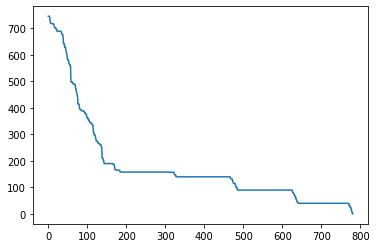

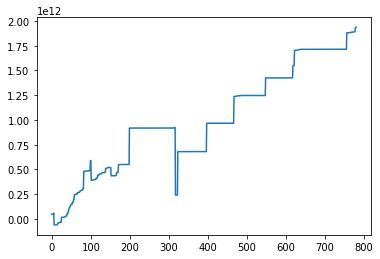

Total Revenue: 1936096643472.6558
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 1
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 2
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 3
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 34455243.871754915
PR_Saumlaki revenue: 0
************************************************
revenue: 34455243.871754915
remaining: 490
iteration: 4
*****

************************************************
revenue: 4927511972.291117
remaining: 472
iteration: 29
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: -489449335.01890796
PR_Saumlaki revenue: 26269248371.153896
************************************************
revenue: 26671694765.29806
remaining: 472
iteration: 30
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: -489449335.01890796
PR_Saumlaki revenue: 26269248371.153896
************************************************
revenue: 26671694765.29806
remaining: 472
iteration: 31
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: -489449335.01890796
PR_Saumlaki revenue: 26269248371.153896
************************************************
revenue: 266716

PR_Ambon revenue: 20322200028.920864
PL1 revenue: 0
PR_Tual revenue: 3987726951.4412465
PR_Saumlaki revenue: 26527411403.3564
************************************************
revenue: 60942858834.00605
remaining: 410
iteration: 54
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: 4885486337.267177
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 0
PR_Tual revenue: 7091149870.30567
PR_Saumlaki revenue: 27847450619.33676
************************************************
revenue: 65366320968.85083
remaining: 400
iteration: 55
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: 4885486337.267177
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 0
PR_Tual revenue: 7091149870.30567
PR_Saumlaki revenue: 27847450619.33676
************************************************
revenue: 65366320968.85083
remaining: 400
iteration: 56
************************************************
TL1 revenue: 5220034113.020361
TL2 rev

PR_Ambon revenue: 20322200028.920864
PL1 revenue: 0
PR_Tual revenue: 62414934273.316124
PR_Saumlaki revenue: 56167268643.250244
************************************************
revenue: 217176197448.5284
remaining: 351
iteration: 78
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: -219904020687.01843
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 0
PR_Tual revenue: 62414934273.316124
PR_Saumlaki revenue: 56167268643.250244
************************************************
revenue: -75779583628.51083
remaining: 350
iteration: 79
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: -219904020687.01843
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 0
PR_Tual revenue: 64537359617.293495
PR_Saumlaki revenue: 58712252192.19451
************************************************
revenue: -71112174735.5892
remaining: 335
iteration: 80
************************************************
TL1 revenue: 5220034113.02

PR_Saumlaki revenue: 60797166649.41903
************************************************
revenue: 15902137754.196632
remaining: 246
iteration: 101
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: -156158675673.6651
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 80079343503.03622
PR_Saumlaki revenue: 60797166649.41903
************************************************
revenue: 15902137754.196632
remaining: 246
iteration: 102
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: -156158675673.6651
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 82342837582.00255
PR_Saumlaki revenue: 60797166649.41903
************************************************
revenue: 18165631833.162956
remaining: 238
iteration: 103
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: -156158675673.6651
PR_Ambon revenue: 

PR_Ambon revenue: 20322200028.920864
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 72850103582.28104
************************************************
revenue: 59139754528.7767
remaining: 191
iteration: 124
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: -133178373288.41428
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 72850103582.28104
************************************************
revenue: 59139754528.7767
remaining: 191
iteration: 125
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: -133178373288.41428
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 72850103582.28104
************************************************
revenue: 59139754528.7767
remaining: 191
iteration: 126
******************************

TL2 revenue: -130451014123.6927
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78862327289.06047
************************************************
revenue: 67879337400.27771
remaining: 171
iteration: 147
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: -130451014123.6927
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78862327289.06047
************************************************
revenue: 67879337400.27771
remaining: 171
iteration: 148
************************************************
TL1 revenue: 5220034113.020361
TL2 revenue: -130451014123.6927
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78862327289.06047
************************************************
revenue: 67879337400.27771
remaining: 171
iteration: 1

PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 170
************************************************
TL1 revenue: 286474943831.8536
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 171
************************************************
TL1 revenue: 286474943831.8536
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 172
************************

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 193
************************************************
TL1 revenue: 286474943831.8536
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 194
************************************************
TL1 revenue: 286474943831.8536
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iterat

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 216
************************************************
TL1 revenue: 286474943831.8536
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 217
************************************************
TL1 revenue: 286474943831.8536
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iterat

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 239
************************************************
TL1 revenue: 286474943831.8536
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 240
************************************************
TL1 revenue: 286474943831.8536
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iterat

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 262
************************************************
TL1 revenue: 286474943831.8536
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iteration: 263
************************************************
TL1 revenue: 286474943831.8536
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 380906985678.78186
remaining: 163
iterat

PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 397200083088.12024
remaining: 146
iteration: 285
************************************************
TL1 revenue: 302768041241.19196
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 397200083088.12024
remaining: 146
iteration: 286
************************************************
TL1 revenue: 302768041241.19196
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 36747442919.430916
PR_Tual revenue: 88283720959.50346
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 397200083088.12024
remaining: 146
iteration: 287
**********************

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 88129526974.62553
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457282194832.62756
remaining: 145
iteration: 308
************************************************
TL1 revenue: 303606652660.8758
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 88129526974.62553
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457282194832.62756
remaining: 145
iteration: 309
************************************************
TL1 revenue: 303606652660.8758
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 88129526974.62553
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457282194832.62756
remaining: 145
iteration

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457036701708.7412
remaining: 144
iteration: 331
************************************************
TL1 revenue: 303606652660.8758
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457036701708.7412
remaining: 144
iteration: 332
************************************************
TL1 revenue: 303606652660.8758
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457036701708.7412
remaining: 144
iteration: 3

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457036701708.7412
remaining: 144
iteration: 354
************************************************
TL1 revenue: 303606652660.8758
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457036701708.7412
remaining: 144
iteration: 355
************************************************
TL1 revenue: 303606652660.8758
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457036701708.7412
remaining: 144
iteration: 3

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457036701708.7412
remaining: 144
iteration: 377
************************************************
TL1 revenue: 303606652660.8758
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457036701708.7412
remaining: 144
iteration: 378
************************************************
TL1 revenue: 303606652660.8758
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 96145137229.13231
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 457036701708.7412
remaining: 144
iteration: 3

PR_Ambon revenue: 20322200028.920864
PL1 revenue: 382664169908.3953
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 743555734388.0043
remaining: 144
iteration: 400
************************************************
TL1 revenue: 303606652660.8758
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 382664169908.3953
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 743555734388.0043
remaining: 144
iteration: 401
************************************************
TL1 revenue: 303606652660.8758
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 382664169908.3953
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 743555734388.0043
remaining: 144
iteration: 402
******************************

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 382664169908.3953
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 843118934049.5117
remaining: 144
iteration: 423
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 382664169908.3953
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 843118934049.5117
remaining: 144
iteration: 424
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 382664169908.3953
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 843118934049.5117
remaining: 144
iteration:

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 382664169908.3953
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 843118934049.5117
remaining: 144
iteration: 446
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 382664169908.3953
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 843118934049.5117
remaining: 144
iteration: 447
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 20322200028.920864
PL1 revenue: 382664169908.3953
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 843118934049.5117
remaining: 144
iteration:

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 24444509898.037422
PL1 revenue: 645224985397.5146
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1109802059407.7478
remaining: 112
iteration: 469
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 24444509898.037422
PL1 revenue: 645224985397.5146
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1109802059407.7478
remaining: 112
iteration: 470
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 25764549114.017784
PL1 revenue: 645224985397.5146
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1111122098623.728
remaining: 105
iteratio

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 27650789419.775444
PL1 revenue: 645224985397.5146
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1113008338929.4858
remaining: 97
iteration: 492
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 27650789419.775444
PL1 revenue: 645224985397.5146
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1113008338929.4858
remaining: 97
iteration: 493
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 27650789419.775444
PL1 revenue: 645224985397.5146
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1113008338929.4858
remaining: 97
iteration:

************************************************
revenue: 1113008338929.4858
remaining: 97
iteration: 515
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 27650789419.775444
PL1 revenue: 645224985397.5146
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1113008338929.4858
remaining: 97
iteration: 516
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 27650789419.775444
PL1 revenue: 645224985397.5146
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1113008338929.4858
remaining: 97
iteration: 517
************************************************
TL1 revenue: 403169852322.38324
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 27650789419.775444
PL1 revenue: 645224

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 799979081006.3265
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 574590836626.3927
remaining: 90
iteration: 539
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 799979081006.3265
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 574590836626.3927
remaining: 90
iteration: 540
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 799979081006.3265
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 574590836626.3927
remaining: 90
iteration: 

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 799979081006.3265
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 574590836626.3927
remaining: 90
iteration: 562
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 799979081006.3265
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 574590836626.3927
remaining: 90
iteration: 563
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 799979081006.3265
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 574590836626.3927
remaining: 90
iteration: 

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 799979081006.3265
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 574590836626.3927
remaining: 90
iteration: 585
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 799979081006.3265
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 574590836626.3927
remaining: 90
iteration: 586
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 799979081006.3265
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 574590836626.3927
remaining: 90
iteration: 

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 968181725179.6921
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 742793480799.7584
remaining: 90
iteration: 608
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 850378264155.2306
remaining: 90
iteration: 609
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 28597883131.894062
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 87884033850.73923
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 850378264155.2306
remaining: 90
iteration

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 631
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 632
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 

TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 654
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 655
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 

PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 677
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 678
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 679
*****************************

PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 700
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 701
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 702
*****************************

PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 723
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 724
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129886119744.02254
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1075766508535.1643
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 864485120216.0576
remaining: 40
iteration: 725
*****************************

PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1241827896722.981
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1030923733616.7972
remaining: 32
iteration: 746
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -129508894531.09958
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1241827896722.981
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1030923733616.7972
remaining: 32
iteration: 747
************************************************
TL1 revenue: -290948839301.64014
TL2 revenue: -128943359291.50084
PR_Ambon revenue: 36726413879.06237
PL1 revenue: 1241827896722.981
PR_Tual revenue: 93862359164.39806
PR_Saumlaki revenue: 78964797683.09561
************************************************
revenue: 1031489268856.396
remaining: 26
iteration: 748
******************************

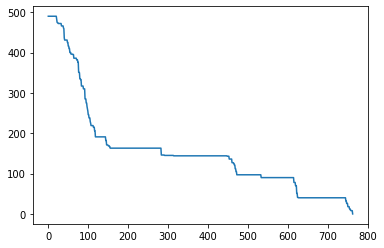

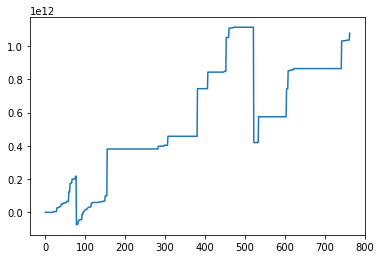

Total Revenue: 1077723061121.8424
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 1
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 2
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 3
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 4
***************************************

PR_Saumlaki revenue: 26269248371.153896
************************************************
revenue: 865200657.1036072
remaining: 466
iteration: 30
************************************************
TL1 revenue: 0
TL2 revenue: -26531466201.29021
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: 235522758.07685024
PR_Saumlaki revenue: 26269248371.153896
************************************************
revenue: 865200657.1036072
remaining: 466
iteration: 31
************************************************
TL1 revenue: 0
TL2 revenue: -26531466201.29021
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: 235522758.07685024
PR_Saumlaki revenue: 26269248371.153896
************************************************
revenue: 865200657.1036072
remaining: 466
iteration: 32
************************************************
TL1 revenue: 0
TL2 revenue: -26531466201.29021
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: 235522758.07685024
PR_Saumlaki reve

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 31151526256.468098
PR_Saumlaki revenue: 27847450619.33676
************************************************
revenue: 62350342522.399445
remaining: 397
iteration: 55
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -24645225895.53255
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 31151526256.468098
PR_Saumlaki revenue: 27847450619.33676
************************************************
revenue: 62350342522.399445
remaining: 397
iteration: 56
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -24645225895.53255
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 31151526256.468098
PR_Saumlaki revenue: 27847450619.33676
************************************************
revenue: 62350342522.399445
remaining: 397
iteration: 57
************************************************
TL1 revenue: 6537506319.250723


PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 45654345709.17394
PR_Saumlaki revenue: 60796565365.05652
************************************************
revenue: 170770659502.0782
remaining: 337
iteration: 79
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: 36323156885.72057
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 45654345709.17394
PR_Saumlaki revenue: 63341548914.000786
************************************************
revenue: 173315643051.02243
remaining: 331
iteration: 80
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: 45089263692.60797
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 45654345709.17394
PR_Saumlaki revenue: 63341548914.000786
************************************************
revenue: 182081749857.90985
remaining: 325
iteration: 81
************************************************
TL1 revenue: 6537506319.250723
TL2 

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54649555385.37924
PR_Saumlaki revenue: 63341548914.000786
************************************************
revenue: -28439613093.155617
remaining: 273
iteration: 102
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -180069378068.12805
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54649555385.37924
PR_Saumlaki revenue: 63341548914.000786
************************************************
revenue: -28439613093.155617
remaining: 273
iteration: 103
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -180069378068.12805
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54649555385.37924
PR_Saumlaki revenue: 63341548914.000786
************************************************
revenue: -28439613093.155617
remaining: 273
iteration: 104
*********************

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54649555385.37924
PR_Saumlaki revenue: 87728016260.0723
************************************************
revenue: 10744692631.325882
remaining: 220
iteration: 125
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -165271539689.71805
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54649555385.37924
PR_Saumlaki revenue: 87728016260.0723
************************************************
revenue: 10744692631.325882
remaining: 220
iteration: 126
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -165271539689.71805
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54649555385.37924
PR_Saumlaki revenue: 87728016260.0723
************************************************
revenue: 10744692631.325882
remaining: 220
iteration: 127
******************************

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 58977720360.98681
PR_Saumlaki revenue: 87651783516.16214
************************************************
revenue: -49502446349.60602
remaining: 196
iteration: 148
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 58977720360.98681
PR_Saumlaki revenue: 87651783516.16214
************************************************
revenue: -49502446349.60602
remaining: 196
iteration: 149
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 58977720360.98681
PR_Saumlaki revenue: 87651783516.16214
************************************************
revenue: -49502446349.60602
remaining: 196
iteration

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 171
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 172
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 173
***************************

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 194
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 195
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 217
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 218
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 240
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 241
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 263
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration: 264
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88538929199.30345
************************************************
revenue: 272312653208.08148
remaining: 169
iteration

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88677655148.35443
************************************************
revenue: 320328294019.9134
remaining: 169
iteration: 286
************************************************
TL1 revenue: 340936915725.7863
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88910600186.57413
************************************************
revenue: 320561239058.13306
remaining: 168
iteration: 287
************************************************
TL1 revenue: 340936915725.7863
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 62277805905.81271
PR_Saumlaki revenue: 88910600186.57413
************************************************
revenue: 320561239058.13306
remaining: 168
iteration:

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 62123611920.93479
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398679690062.8904
remaining: 145
iteration: 309
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61738353202.130974
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398294431344.08655
remaining: 145
iteration: 310
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61738353202.130974
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398294431344.08655
remaining: 145
iteration: 311

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398434196939.004
remaining: 144
iteration: 332
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398434196939.004
remaining: 144
iteration: 333
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398434196939.004
remaining: 144
iteration: 334
***

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398434196939.004
remaining: 144
iteration: 355
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398434196939.004
remaining: 144
iteration: 356
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398434196939.004
remaining: 144
iteration: 357
***

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398434196939.004
remaining: 144
iteration: 378
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398434196939.004
remaining: 144
iteration: 379
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 398434196939.004
remaining: 144
iteration: 380
***

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 684953229618.267
remaining: 144
iteration: 401
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 684953229618.267
remaining: 144
iteration: 402
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 684953229618.267
remaining: 144
iteration: 403
***

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 784516429279.7744
remaining: 144
iteration: 424
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 784516429279.7744
remaining: 144
iteration: 425
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 784516429279.7744
remaining: 144
iteration: 42

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 784516429279.7744
remaining: 144
iteration: 447
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 784516429279.7744
remaining: 144
iteration: 448
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 387824630789.2646
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 789676890160.6437
remaining: 143
iteration: 44

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 25581395091.99297
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 1051199554638.0104
remaining: 112
iteration: 470
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 26901434307.97333
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 1052519593853.9907
remaining: 105
iteration: 471
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 26901434307.97333
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 1052519593853.9907
remaining: 105
iteration:

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 1054405834159.7483
remaining: 97
iteration: 493
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 1054405834159.7483
remaining: 97
iteration: 494
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 1054405834159.7483
remaining: 97
iteration: 49

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 1054405834159.7483
remaining: 97
iteration: 516
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 1054405834159.7483
remaining: 97
iteration: 517
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 1054405834159.7483
remaining: 97
iteration: 51

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29199428315.102108
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 515452857844.4081
remaining: 97
iteration: 539
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29404777264.54202
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 515658206793.848
remaining: 97
iteration: 540
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29404777264.54202
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 515658206793.848
remaining: 97
iteration: 541


TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 515988197855.15564
remaining: 90
iteration: 562
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 515988197855.15564
remaining: 90
iteration: 563
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 515988197855.15564
remaining: 90
iteration: 

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 515988197855.15564
remaining: 90
iteration: 585
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 515988197855.15564
remaining: 90
iteration: 586
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 515988197855.15564
remaining: 90
iteration: 

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 968181460176.6921
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 684190711027.0211
remaining: 90
iteration: 608
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 791775494382.4933
remaining: 90
iteration: 609
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 61878118797.048515
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 791775494382.4933
remaining: 90
iteration: 6

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteration: 631
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteration: 632
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteratio

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteration: 654
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteration: 655
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteratio

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteration: 677
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteration: 678
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteratio

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteration: 700
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteration: 701
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteratio

TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteration: 723
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteration: 724
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229770610902.34738
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 805881739987.5398
remaining: 40
iteratio

PL1 revenue: 1241827631719.981
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 972320353388.2794
remaining: 32
iteration: 746
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -229393385689.4244
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1241827631719.981
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 972320353388.2794
remaining: 32
iteration: 747
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -228827850449.82568
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1241827631719.981
PR_Tual revenue: 67856444110.707405
PR_Saumlaki revenue: 90559366594.1835
************************************************
revenue: 972885888627.8782
remaining: 26
iteration: 748
************************************************
TL1 revenue: -2363

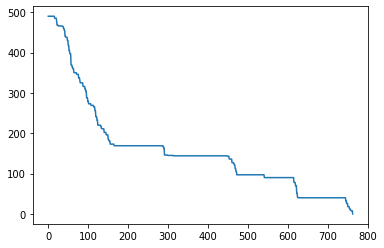

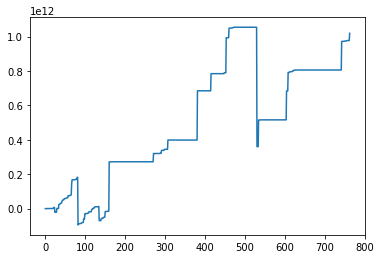

Total Revenue: 1019119680893.3246
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 1
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 2
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 3
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 4
***************************************

************************************************
revenue: -44108194402.14598
remaining: 461
iteration: 29
************************************************
TL1 revenue: 0
TL2 revenue: -51724102344.99307
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: 235522758.07685024
PR_Saumlaki revenue: 6488489455.607169
************************************************
revenue: -44108194402.14598
remaining: 461
iteration: 30
************************************************
TL1 revenue: 0
TL2 revenue: -51724102344.99307
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: 235522758.07685024
PR_Saumlaki revenue: 10638252400.616877
************************************************
revenue: -39958431457.13628
remaining: 453
iteration: 31
************************************************
TL1 revenue: 0
TL2 revenue: -51724102344.99307
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: 235522758.07685024
PR_Saumlaki revenue: 10638252400.616877
**************

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 33824388801.93711
PR_Saumlaki revenue: 33015900858.963577
************************************************
revenue: 44999019163.79241
remaining: 381
iteration: 54
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -49837862039.23541
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 34103923561.807903
PR_Saumlaki revenue: 33015900858.963577
************************************************
revenue: 45278553923.66321
remaining: 380
iteration: 55
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -49837862039.23541
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 34103923561.807903
PR_Saumlaki revenue: 33015900858.963577
************************************************
revenue: 45278553923.66321
remaining: 380
iteration: 56
************************************************
TL1 revenue: 6537506319.250723
T

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 48606743014.513756
PR_Saumlaki revenue: 55413561619.31406
************************************************
revenue: 143147416917.97266
remaining: 333
iteration: 78
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: 11130520742.017712
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 48606743014.513756
PR_Saumlaki revenue: 55978455998.98421
************************************************
revenue: 143712311297.64282
remaining: 329
iteration: 79
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: 11130520742.017712
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 48606743014.513756
PR_Saumlaki revenue: 55978455998.98421
************************************************
revenue: 143712311297.64282
remaining: 329
iteration: 80
************************************************
TL1 revenue: 6537506319.250723


PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 57675104558.208954
************************************************
revenue: 42509393122.394966
remaining: 264
iteration: 101
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -103314538648.16125
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 57675104558.208954
************************************************
revenue: 42509393122.394966
remaining: 264
iteration: 102
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -103314538648.16125
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 57675104558.208954
************************************************
revenue: 42509393122.394966
remaining: 264
iteration: 103
*********************

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 74888700918.238
************************************************
revenue: 74520827860.83401
remaining: 223
iteration: 124
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -88516700269.75125
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 76771719074.17422
************************************************
revenue: 76403846016.77023
remaining: 219
iteration: 125
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -88516700269.75125
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 76771719074.17422
************************************************
revenue: 76403846016.77023
remaining: 219
iteration: 126
*******************************

TL2 revenue: -212190378634.12915
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 57847244331.25363
PR_Saumlaki revenue: 76695486330.26407
************************************************
revenue: -44008987297.01904
remaining: 201
iteration: 147
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -212190378634.12915
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 57847244331.25363
PR_Saumlaki revenue: 76695486330.26407
************************************************
revenue: -44008987297.01904
remaining: 201
iteration: 148
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -212190378634.12915
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 58223835824.31944
PR_Saumlaki revenue: 76695486330.26407
************************************************
revenue: -43632395803.95323
remaining: 197
iteration

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 170
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 171
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 1

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 193
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 194
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 1

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 216
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 217
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 2

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 239
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 240
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 2

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 262
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 263
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 2

TL1 revenue: 340936915725.7863
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 79212253339.78558
************************************************
revenue: 328442462199.4199
remaining: 168
iteration: 285
************************************************
TL1 revenue: 340936915725.7863
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 330091228607.0293
remaining: 163
iteration: 286
************************************************
TL1 revenue: 340936915725.7863
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 330091228607.0

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61558055261.121765
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406560913204.1772
remaining: 145
iteration: 308
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61558055261.121765
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406560913204.1772
remaining: 145
iteration: 309
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61558055261.121765
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406560913204.1772
remaining: 145
iteration: 3

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 331
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 332
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 333


TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 354
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 355
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 356


TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 377
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 378
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 379


TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 692834452759.554
remaining: 144
iteration: 400
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 692834452759.554
remaining: 144
iteration: 401
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 692834452759.554
remaining: 144
iteration: 402
***

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 423
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 424
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 42

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 446
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 447
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 44

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 25581395091.99297
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1059080777779.2971
remaining: 112
iteration: 469
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 25581395091.99297
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1059080777779.2971
remaining: 112
iteration: 470
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 26901434307.97333
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1060400816995.2776
remaining: 105
iteration:

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 492
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 493
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 49

PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 515
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 516
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 517
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29199428315.102108
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523334080985.69495
remaining: 97
iteration: 538
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29199428315.102108
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523334080985.69495
remaining: 97
iteration: 539
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29404777264.54202
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523539429935.1348
remaining: 97
iteration:

PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 561
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 562
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 563
*****************************

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 584
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 585
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 968181460176.6921
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 692071934168.3081
remaining: 90
iteration: 607
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 968181460176.6921
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 692071934168.3081
remaining: 90
iteration: 608
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 799656717523.7803
remaining: 90
iteration: 60

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 630
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 631
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteratio

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 653
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 654
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteratio

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 676
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 677
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteratio

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 699
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 700
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteratio

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 722
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 723
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteratio

PL1 revenue: 1241827631719.981
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 979824351316.6433
remaining: 40
iteration: 745
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211248259041.536
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1241827631719.981
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 980201576529.5664
remaining: 32
iteration: 746
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211248259041.536
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1241827631719.981
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 980201576529.5664
remaining: 32
iteration: 747
************************************************
TL1 revenue: -2363923

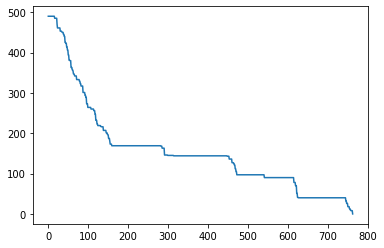

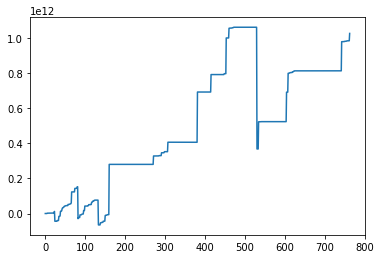

Total Revenue: 1027000904034.6113
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 1
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 2
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 3
************************************************
TL1 revenue: 0
TL2 revenue: 0
PR_Ambon revenue: 0
PL1 revenue: 0
PR_Tual revenue: 0
PR_Saumlaki revenue: 0
************************************************
revenue: 0
remaining: 490
iteration: 4
***************************************

************************************************
revenue: -44108194402.14598
remaining: 461
iteration: 30
************************************************
TL1 revenue: 0
TL2 revenue: -51724102344.99307
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: 235522758.07685024
PR_Saumlaki revenue: 10638252400.616877
************************************************
revenue: -39958431457.13628
remaining: 453
iteration: 31
************************************************
TL1 revenue: 0
TL2 revenue: -51724102344.99307
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: 235522758.07685024
PR_Saumlaki revenue: 10638252400.616877
************************************************
revenue: -39958431457.13628
remaining: 453
iteration: 32
************************************************
TL1 revenue: 0
TL2 revenue: -51724102344.99307
PR_Ambon revenue: 891895729.1630721
PL1 revenue: 0
PR_Tual revenue: 235522758.07685024
PR_Saumlaki revenue: 10638252400.616877
*************

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 34103923561.807903
PR_Saumlaki revenue: 33015900858.963577
************************************************
revenue: 45278553923.66321
remaining: 380
iteration: 55
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -49837862039.23541
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 34103923561.807903
PR_Saumlaki revenue: 33015900858.963577
************************************************
revenue: 45278553923.66321
remaining: 380
iteration: 56
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -49837862039.23541
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 34103923561.807903
PR_Saumlaki revenue: 33015900858.963577
************************************************
revenue: 45278553923.66321
remaining: 380
iteration: 57
************************************************
TL1 revenue: 6537506319.250723


PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 48606743014.513756
PR_Saumlaki revenue: 55978455998.98421
************************************************
revenue: 143712311297.64282
remaining: 329
iteration: 79
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: 11130520742.017712
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 48606743014.513756
PR_Saumlaki revenue: 55978455998.98421
************************************************
revenue: 143712311297.64282
remaining: 329
iteration: 80
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: 19896627548.905113
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 0
PR_Tual revenue: 48606743014.513756
PR_Saumlaki revenue: 55978455998.98421
************************************************
revenue: 152478418104.5302
remaining: 323
iteration: 81
************************************************
TL1 revenue: 6537506319.250723
T

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 57675104558.208954
************************************************
revenue: 42509393122.394966
remaining: 264
iteration: 102
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -103314538648.16125
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 57675104558.208954
************************************************
revenue: 42509393122.394966
remaining: 264
iteration: 103
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -103314538648.16125
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 57675104558.208954
************************************************
revenue: 42509393122.394966
remaining: 264
iteration: 104
*********************

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 76771719074.17422
************************************************
revenue: 76403846016.77023
remaining: 219
iteration: 125
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -88516700269.75125
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 76771719074.17422
************************************************
revenue: 76403846016.77023
remaining: 219
iteration: 126
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -88516700269.75125
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 54510166536.754875
PR_Saumlaki revenue: 76771719074.17422
************************************************
revenue: 76403846016.77023
remaining: 219
iteration: 127
*****************************

TL2 revenue: -212190378634.12915
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 57847244331.25363
PR_Saumlaki revenue: 76695486330.26407
************************************************
revenue: -44008987297.01904
remaining: 201
iteration: 148
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -212190378634.12915
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 58223835824.31944
PR_Saumlaki revenue: 76695486330.26407
************************************************
revenue: -43632395803.95323
remaining: 197
iteration: 149
************************************************
TL1 revenue: 6537506319.250723
TL2 revenue: -212190378634.12915
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 5642069133.4652605
PR_Tual revenue: 58223835824.31944
PR_Saumlaki revenue: 76695486330.26407
************************************************
revenue: -43632395803.95323
remaining: 197
iteration

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 171
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 172
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 173
******************************

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 194
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 195
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 196
******************************

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 217
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 218
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 2

PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 240
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 241
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 242
******************************

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 263
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 264
************************************************
TL1 revenue: 293060000863.0054
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 78840582352.51491
************************************************
revenue: 280193876349.3683
remaining: 169
iteration: 2

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 330091228607.0293
remaining: 163
iteration: 286
************************************************
TL1 revenue: 340936915725.7863
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 330091228607.0293
remaining: 163
iteration: 287
************************************************
TL1 revenue: 340936915725.7863
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 36747442919.430916
PR_Tual revenue: 61712249245.99969
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 330091228607.0293
remaining: 163
iteration: 2

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61558055261.121765
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406560913204.1772
remaining: 145
iteration: 309
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61558055261.121765
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406560913204.1772
remaining: 145
iteration: 310
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61172796542.31795
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406175654485.37335
remaining: 145
iteration: 3

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 332
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 333
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 334


TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 355
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 356
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 357


TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 378
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 379
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 96145137229.13231
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 406315420080.2909
remaining: 144
iteration: 380


TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 692834452759.554
remaining: 144
iteration: 401
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 692834452759.554
remaining: 144
iteration: 402
************************************************
TL1 revenue: 358163099998.1107
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 692834452759.554
remaining: 144
iteration: 403
***

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 424
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 425
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 42

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 447
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 382664169908.3953
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 792397652421.0613
remaining: 144
iteration: 448
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 21459085222.87641
PL1 revenue: 387824630789.2646
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 797558113301.9307
remaining: 143
iteration: 44

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 25581395091.99297
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1059080777779.2971
remaining: 112
iteration: 470
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 26901434307.97333
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1060400816995.2776
remaining: 105
iteration: 471
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 26901434307.97333
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1060400816995.2776
remaining: 105
iteration:

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 493
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 494
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 49

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 516
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 517
************************************************
TL1 revenue: 457726299659.61816
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 28787674613.73099
PL1 revenue: 645224985397.5146
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 1062287057301.0352
remaining: 97
iteration: 51

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29199428315.102108
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523334080985.69495
remaining: 97
iteration: 539
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29404777264.54202
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523539429935.1348
remaining: 97
iteration: 540
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29404777264.54202
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523539429935.1348
remaining: 97
iteration: 5

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 562
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 563
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 585
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 586
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 799978947004.8265
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 523869420996.44244
remaining: 90
iteration: 

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 968181460176.6921
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 692071934168.3081
remaining: 90
iteration: 608
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 799656717523.7803
remaining: 90
iteration: 609
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 29734768325.84961
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 61312562137.23549
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 799656717523.7803
remaining: 90
iteration: 6

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 631
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 632
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteratio

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 654
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 655
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteratio

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 677
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 678
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteratio

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 700
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 701
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteratio

TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 723
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteration: 724
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211625484254.45898
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1075766243532.1643
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 813762963128.8267
remaining: 40
iteratio

TL2 revenue: -211248259041.536
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1241827631719.981
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 980201576529.5664
remaining: 32
iteration: 746
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -211248259041.536
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1241827631719.981
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 980201576529.5664
remaining: 32
iteration: 747
************************************************
TL1 revenue: -236392391964.40518
TL2 revenue: -210682723801.9373
PR_Ambon revenue: 37862688617.237175
PL1 revenue: 1241827631719.981
PR_Tual revenue: 67290887450.89438
PR_Saumlaki revenue: 80861019747.39496
************************************************
revenue: 980767111769.165
remaining: 26
iteration: 748
**

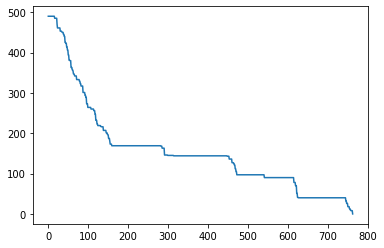

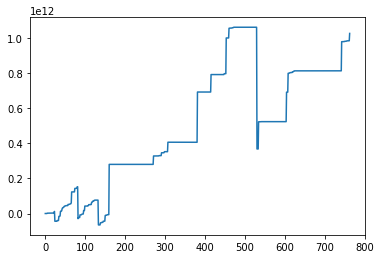

Total Revenue: 1027000904034.6113


In [108]:
ship_names = ship_df['Ship_Name'].to_list()
n_pop = 5
elite_n = 2
pop = initial_population(ship_names, n_pop)
rank = rankRoutes(pop,available_ship,ports)
selected = selection(rank, elite_n)
matingpool = matingPool(pop,selected)

In [109]:
selected = selection(rank, elite_n)
matingpool = matingPool(pop,selected)

In [128]:
matingpool[4]

{'TL1': [Utama:Tanjung Perak,
  Pengumpan:Leksula,
  Pengumpan:Lakor,
  Pengumpul:Namrole,
  Pengumpan:Marsela,
  Pengumpul:Moa,
  Pengumpan:Nila,
  Pengumpan:Eray,
  Pengumpan:Amahai,
  Pengumpan:Fogi,
  Pengumpan:Bula,
  Pengumpan:Larat,
  Pengumpul:Saumlaki,
  Pengumpan:Dawera/Dawelor,
  Pengumpan:Bebar,
  Pengumpan:Wulur,
  Pengumpan:Adault/Lingat,
  Pengumpan:Ilwaki,
  Pengumpul:Moa,
  Pengumpan:Kisar1,
  Pengumpul:Dobo,
  Pengumpan:P.Geser,
  Pengumpan:Arwala/Sutilirang,
  Pengumpan:Taniwel,
  Pengumpan:Buano,
  Pengumpul:Namlea,
  Pengumpul:Kisar,
  Pengumpul:Namrole,
  Pengumpan:Werinama,
  Pengumpul:Ambon],
 'TL2': [Utama:Makassar,
  Pengumpan:Larat,
  Pengumpan:Ilwaki,
  Pengumpan:Lakor,
  Pengumpan:Fadol,
  Pengumpul:Banda Neira,
  Pengumpul:Namlea,
  Pengumpan:Eray,
  Pengumpul:Tual,
  Pengumpul:Dobo,
  Pengumpan:Dawera/Dawelor,
  Pengumpan:Mangur,
  Pengumpan:P.Tior,
  Pengumpul:Moa,
  Pengumpan:Adault/Lingat,
  Pengumpan:Holat,
  Pengumpul:Moa,
  Pengumpan:Marsela,
  Peng

In [ ]:
revenue,remaining_history,revenue_history,processtime = simulate_fitness(available_ship,ports,print_progress=True)

False

In [142]:
parent1 = matingpool[0]
parent2 = matingpool[1]

In [183]:
breed(parent1,parent2)

{'TL1': [Utama:Tanjung Perak,
  Pengumpul:Kisar,
  Pengumpan:Werinama,
  Pengumpan:Leksula,
  Pengumpan:Eray,
  Pengumpan:Marsela,
  Pengumpan:Taniwel,
  Pengumpul:Ambon,
  Pengumpan:Kisar1,
  Pengumpul:Moa,
  Pengumpan:Nila,
  Pengumpan:Bebar,
  Pengumpan:Wulur,
  Pengumpan:Arwala/Sutilirang,
  Pengumpan:Amahai,
  Pengumpan:Adault/Lingat,
  Pengumpan:P.Geser,
  Pengumpul:Namrole,
  Pengumpan:Lakor,
  Pengumpul:Saumlaki,
  Pengumpan:Fogi,
  Pengumpan:Buano,
  Pengumpan:Bula,
  Pengumpan:Ilwaki,
  Pengumpan:Larat,
  Pengumpul:Namrole,
  Pengumpul:Dobo,
  Pengumpan:Dawera/Dawelor,
  Pengumpul:Namlea,
  Pengumpul:Moa],
 'TL2': [Utama:Makassar,
  Pengumpan:Larat,
  Pengumpan:Ilwaki,
  Pengumpan:Lakor,
  Pengumpan:Fadol,
  Pengumpul:Banda Neira,
  Pengumpul:Namlea,
  Pengumpan:Eray,
  Pengumpul:Tual,
  Pengumpul:Dobo,
  Pengumpan:Dawera/Dawelor,
  Pengumpan:Mangur,
  Pengumpan:P.Tior,
  Pengumpul:Moa,
  Pengumpan:Adault/Lingat,
  Pengumpan:Holat,
  Pengumpul:Moa,
  Pengumpan:Marsela,
  Peng

In [180]:
child = random.choice([childP1,childP2])
child

{'TL1': [Utama:Tanjung Perak,
  Pengumpul:Kisar,
  Pengumpan:Werinama,
  Pengumpan:Leksula,
  Pengumpan:Eray,
  Pengumpan:Marsela,
  Pengumpan:Taniwel,
  Pengumpul:Ambon,
  Pengumpan:Kisar1,
  Pengumpul:Moa,
  Pengumpan:Nila,
  Pengumpan:Bebar,
  Pengumpan:Wulur,
  Pengumpan:Arwala/Sutilirang,
  Pengumpan:Amahai,
  Pengumpan:Adault/Lingat,
  Pengumpan:P.Geser,
  Pengumpul:Namrole,
  Pengumpan:Lakor,
  Pengumpul:Saumlaki,
  Pengumpan:Fogi,
  Pengumpan:Buano,
  Pengumpan:Bula,
  Pengumpan:Ilwaki,
  Pengumpan:Larat,
  Pengumpul:Namrole,
  Pengumpul:Dobo,
  Pengumpan:Dawera/Dawelor,
  Pengumpul:Namlea,
  Pengumpul:Moa],
 'TL2': [Utama:Makassar,
  Pengumpan:Larat,
  Pengumpan:Ilwaki,
  Pengumpan:Lakor,
  Pengumpan:Fadol,
  Pengumpul:Banda Neira,
  Pengumpul:Namlea,
  Pengumpan:Eray,
  Pengumpul:Tual,
  Pengumpul:Dobo,
  Pengumpan:Dawera/Dawelor,
  Pengumpan:Mangur,
  Pengumpan:P.Tior,
  Pengumpul:Moa,
  Pengumpan:Adault/Lingat,
  Pengumpan:Holat,
  Pengumpul:Moa,
  Pengumpan:Marsela,
  Peng

In [169]:
a = {'a':'aaa',
     'b':'bbb',
     'c':'ccc'}
b = {'a':'xxx',
     'b':'yyy',
     'c':'zzz'}

key = list(a.keys())


In [170]:
key

['a', 'b', 'c']